## Imports

In [1]:
import os
import data_loading as dl
import time
import math
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from sklearn.metrics import mean_absolute_error

## Part 1: Loading the Experiment(s) Data
Based on the data retrieved from `data_analysis.ipynb`, get that data into a format capable of being used by a Machine Learning model.

<span style="color: orange;">**Future Experiment:** Generating multiple months or simply estimating a year in advance.</span>

In [2]:
MODEL_DATA_DIRECTORY = '../model_data/wheat_model_data/'
TEST_SIZE = 0.2
OUTPUT_COLUMN_NAME = 'Price'

# Model Architecture
SEQ_LEN = 3
HEAD_SIZE = 64
NUM_HEADS = 8
FF_DIM = 16

# ML Optimizer
LEARNING_RATE = 1e-3
CLIP_VALUE = 0.5 # Gradient Clipping (https://neptune.ai/blog/understanding-gradient-clipping-and-how-it-can-fix-exploding-gradients-problem)
DROP_OUT_RATE = 0.2

# Training
BATCH_SIZE = 1 
NUM_EPOCHS = 5

d_model = NUM_HEADS

In [3]:
# Get the number of features for this model (given the model_data chosen)
sample_file_path = os.path.join(MODEL_DATA_DIRECTORY, os.listdir(MODEL_DATA_DIRECTORY)[0])
sample_columns = pd.read_csv(sample_file_path).columns[1:] 

In [4]:
model_data = dl.get_data_from_dir(MODEL_DATA_DIRECTORY, sample_columns)

/Users/sydneybalboni/Documents/GitHub/Predicting-Commodity-Food-Pricing/pytorch_conversion/data_loading.py:200: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  model_data = pd.concat([model_data, data_to_concat], ignore_index=True).drop(columns=['Unnamed: 0'])


In [5]:
model_data.columns

Index(['Date', 'Price', 'Proteus2', 'Food Price Index', 'Cereals Price Index',
       'Wheat Futures', 'Harvest', 'Sentiment'],
      dtype='object')

In [6]:
inputs_and_outputs = model_data.apply(dl.div_inputs_and_outputs, axis=1)
inputs = inputs_and_outputs['inputs'].tolist(); outputs = inputs_and_outputs['output'].tolist()

x_train, x_test, y_train, y_test = train_test_split(inputs, outputs, test_size=TEST_SIZE, shuffle=False) 

x_train_tensor, x_test_tensor, y_train_tensor, y_test_tensor = dl.format_for_ML_usage_torch(inputs, outputs)

train_data = torch.utils.data.TensorDataset(x_train_tensor, y_train_tensor)
test_data = torch.utils.data.TensorDataset(x_test_tensor, y_test_tensor)

# Print the shapes of the data
print(f"x_train_tensor.shape: {x_train_tensor.shape}")
print(f"y_train_tensor.shape: {y_train_tensor.shape}")

num_features = x_train_tensor.shape[2]

x_train_tensor.shape: torch.Size([721, 3, 5])
y_train_tensor.shape: torch.Size([721, 1])


## Part 2: Building Complex ML Models

### Model 1: Simple, 1-Layer Transformer

In [7]:
class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_len=5000):
        super(PositionalEncoding, self).__init__()
        # Create a long enough positional encoding
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * -(math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0).transpose(0, 1)
        # Register as a buffer that is not a model parameter
        self.register_buffer('pe', pe)

    def forward(self, x):
        pe = self.pe[:x.size(1), :]  
        return x + pe

In [8]:
class TransformerBlock(nn.Module):
    def __init__(self, d_model, head_size, num_heads, ff_dim, dropout=0):
        super(TransformerBlock, self).__init__()
        self.attention = nn.MultiheadAttention(embed_dim=d_model, num_heads=num_heads, dropout=dropout)
        self.conv1 = nn.Conv1d(in_channels=d_model, out_channels=ff_dim, kernel_size=1)
        self.conv2 = nn.Conv1d(in_channels=ff_dim, out_channels=d_model, kernel_size=1)
        self.layernorm1 = nn.LayerNorm(d_model)
        self.layernorm2 = nn.LayerNorm(d_model)
        self.dropout = nn.Dropout(dropout)

    def forward(self, query, key, value):
        # Note: MultiheadAttention expects input of shape (L, N, E) where L is the sequence length, N is the batch size, and E is the embedding dimension.
        attn_output, _ = self.attention(query, key, value)
        out1 = self.layernorm1(query + attn_output)
        
        # Conv1D layers expect input of shape (N, C, L), hence we permute
        out1_permuted = out1.permute(1, 2, 0)
        ff_output = F.relu(self.conv1(out1_permuted))
        ff_output = self.conv2(ff_output)
        
        # Permute back to match the MultiheadAttention output shape
        ff_output = ff_output.permute(2, 0, 1)
        out2 = self.layernorm2(out1 + self.dropout(ff_output))
        
        return out2


In [9]:
class TransformerModel(nn.Module):
    def __init__(self, seq_len, num_features, d_model, head_size, num_heads, ff_dim, dropout=0, num_transformers=10):
        super(TransformerModel, self).__init__()  
        self.seq_len = seq_len
        self.num_features = num_features
        self.d_model = d_model
        self.input_projection = nn.Linear(num_features, d_model)
        self.pos_encoding = PositionalEncoding(d_model, seq_len)
        self.transformers = nn.ModuleList([
            TransformerBlock(d_model, head_size, num_heads, ff_dim, dropout) 
            for _ in range(num_transformers)
        ])
        self.global_avg_pooling = nn.AdaptiveAvgPool1d(1)
        self.output_layer = nn.Linear(d_model, 1)

    def forward(self, x):
        if x.size(1) != self.seq_len:
            raise ValueError(f"Expected sequence length {self.seq_len}, but got {x.size(1)}")

        x = self.input_projection(x)  # Projects input to d_model dimensions
        x = x + self.pos_encoding(x)  # Apply positional encoding

        for transformer in self.transformers:
            x = transformer(x, x, x)  # Process through transformer blocks

        x = x.mean(dim=1, keepdim=True)  # Aggregate features
        x = self.output_layer(x)  # Apply the output layer to get the final prediction
        
        return x

In [10]:
# Define the model, loss function, and optimizer
model = TransformerModel(seq_len=SEQ_LEN, num_features=num_features, d_model=d_model, head_size=HEAD_SIZE, num_heads=NUM_HEADS, ff_dim=FF_DIM, dropout=DROP_OUT_RATE)
criterion = nn.L1Loss()
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

## Part 3: Training the Model
This section is specifically for training the model built in the previous section. Some contants (`NUM_EPOCHS`, `BATCH_SIZE`) are provided and should be the only required parameters to adjust for this section of the experiment. 

A plot of the loss throughout the training process is provided for easy understanding about if the model is overfitting or underfitting. For a review of these concepts, see [this article](https://www.analyticsfordecisions.com/overfitting-and-underfitting/#:~:text=Overfitting%20happens%20when%20the%20model%20is%20too%20complex,poor%20performance%20on%20both%20training%20and%20test%20datasets.).
<br/><br/>
**Potential Future Parameters**
* **Regularization:** L1, L2, Dropout; helps prevent overfitting

In [11]:
# def learning_rate_scheduler(epoch, lr):
#     """
#     Learning rate scheduler
#     :param int epoch: current epoch
#     :param float lr: current learning rate
#     """
#     if epoch < 15:
#         return lr
#     else:
#         return lr * tf.math.exp(-0.1)
    
# callback = LearningRateScheduler(learning_rate_scheduler)

In [12]:
train_loader = torch.utils.data.DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=False)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=BATCH_SIZE, shuffle=False)

# Training function doesn't need major changes, but be mindful of the input and output dimensions during training
def train(model, data_loader, optimizer, criterion):
    model.train()  # Set the model to training mode
    total_loss = 0
    for batch, (input, target) in enumerate(data_loader):
        optimizer.zero_grad()
        # Forward pass
        output = model(input)
        # Squeeze the output to remove unnecessary dimensions
        output = output.squeeze()  # This changes shape from [batch_size, 1, 1] to [batch_size]
        # Ensure target is the correct shape. If necessary, reshape or squeeze.
        if target.dim() > 1:
            target = target.squeeze()  # Adjust this based on the actual shape of your targets
        # Calculate loss
        loss = criterion(output, target)
        # Backward pass
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    return total_loss / len(data_loader)

# Training loop
train_loss = []
happy = ':)'
for epoch in range(1, NUM_EPOCHS + 1):
    epoch_start_time = time.time()
    train_loss.append(train(model, train_loader, optimizer, criterion))
    epoch_end_time = time.time()
    if len(train_loss) > 1 and train_loss[-1] < train_loss[-2]:
        happy = ':)'
    elif len(train_loss) > 1 and train_loss[-1] >= train_loss[-2]:
        happy = ':('
    print(f'| epoch {epoch:3d} | train_loss {train_loss[-1]:5.2f} {happy} | time {epoch_end_time - epoch_start_time:5.2f} sec | ETA {((epoch_end_time - epoch_start_time) * (NUM_EPOCHS - epoch)) / 60:5.2f} min |')


/Users/sydneybalboni/Documents/GitHub/Predicting-Commodity-Food-Pricing/.venv/lib/python3.11/site-packages/torch/nn/modules/loss.py:101: UserWarning: Using a target size (torch.Size([])) that is different to the input size (torch.Size([3])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)


| epoch   1 | train_loss  0.14 :) | time 10.86 sec | ETA  0.72 min |
| epoch   2 | train_loss  0.13 :) | time  9.77 sec | ETA  0.49 min |
| epoch   3 | train_loss  0.13 :( | time  9.77 sec | ETA  0.33 min |
| epoch   4 | train_loss  0.13 :( | time 10.05 sec | ETA  0.17 min |
| epoch   5 | train_loss  0.13 :) | time  9.91 sec | ETA  0.00 min |


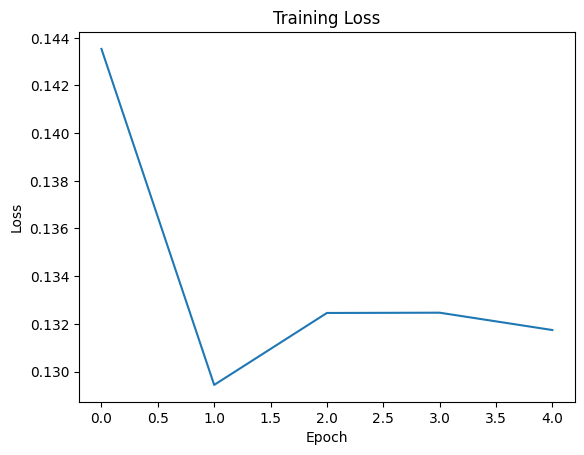

In [13]:
# Plot the loss over time
plt.plot(train_loss)
plt.title('Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

## Part 4: Examining Results
In this section, we're plotting the model's predictions versus the actual price point for the commodity in question. However, one plot focuses specifically on the testing data only (this is a better plot to see how well the model is performing/generalizing) and the other focuses on the entire dataset (this is a better plot to see if the model is correlating to the provided dataset at all).

Therefore, when **evaluating the performance** of the model, **the first plot should be used.** 

In [17]:
# Ensure the model is in evaluation mode
model.eval()
predictions = []

with torch.no_grad():
    for i in range(0, len(x_test_tensor), BATCH_SIZE):
        batch = x_test_tensor[i:i+BATCH_SIZE]
        preds = model(batch)
        preds = preds.squeeze().tolist()
        predictions.extend(preds)

# Ensure predictions are in the correct shape
# Flatten or reshape predictions to match the target's shape
print('predictions shape:', np.array(predictions).shape)
predictions_tensor = torch.tensor(predictions, dtype=torch.float32)

# Ensure y_test_tensor and predictions_tensor have the same number of samples
# This step is crucial to avoid dimension mismatch
if predictions_tensor.shape[0] != y_test_tensor.shape[0]:
    raise ValueError(f"Mismatch in number of samples: y_test_tensor has {y_test_tensor.shape[0]} samples, predictions_tensor has {predictions_tensor.shape[0]} samples")

print('y_test example:', y_test[:10])
print('predictions example:', predictions[:10])
print('y_test shape:', y_test_tensor.shape)
print('predictions shape:', predictions_tensor.shape)

# Plotting
plt.figure(figsize=(10, 5))
plt.plot(y_test_tensor.numpy().flatten(), label='Actual')
plt.plot(predictions_tensor.numpy().flatten(), label='Predicted')
plt.title('Model Predictions (Testing Data Only)')
plt.ylabel('Price')
plt.xlabel('Months')
plt.legend()
plt.show()

# Calculate the Mean Absolute Error
final_mae = mean_absolute_error(y_test_tensor.numpy(), predictions_tensor.numpy())
print('Mean Absolute Error (FINAL ACCURACY METRIC):', final_mae)


AssertionError: The number of predictions does not match the number of sequences.

In [15]:
# Save the model to saved_models
model.save(f'saved_models/wheat_price_transformer_model_{final_mae}.h5')

AttributeError: 'TransformerModel' object has no attribute 'save'